# Generate Data

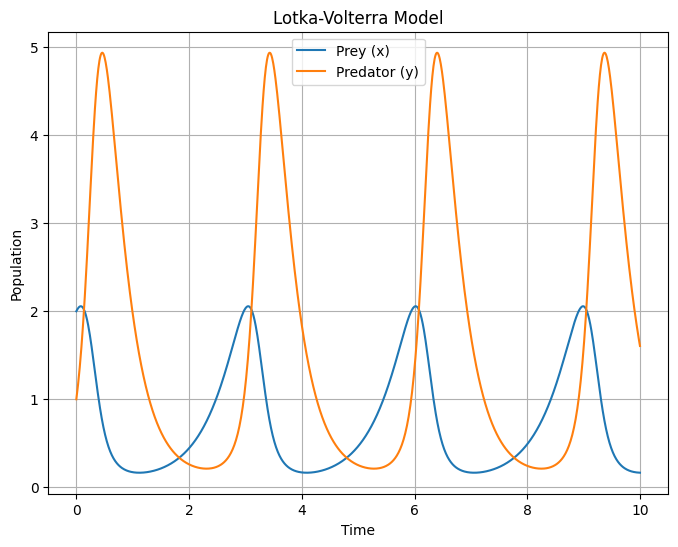

In [24]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt

def lotka_volterra(y, t, alpha, beta, delta, gamma):
    x, y = y
    dx_dt = alpha * x - beta * x * y
    dy_dt = delta * x * y - gamma * y
    return [dx_dt, dy_dt]

# Parameters
alpha = 2
beta = 4/3
delta = 4
gamma = 3

# Initial values
x0 = 2  # Initial prey population
y0 = 1   # Initial predator population
initial_conditions = [x0, y0]

# Time points
t = np.linspace(0, 10, 1000)  # Time span

# Solve the differential equations
solution = odeint(lotka_volterra, initial_conditions, t, args=(alpha, beta, delta, gamma))

# Plot the results
plt.figure(figsize=(8, 6))
plt.plot(t, solution[:, 0], label='Prey (x)')
plt.plot(t, solution[:, 1], label='Predator (y)')
plt.title('Lotka-Volterra Model')
plt.xlabel('Time')
plt.ylabel('Population')
plt.legend()
plt.grid(True)
plt.show()


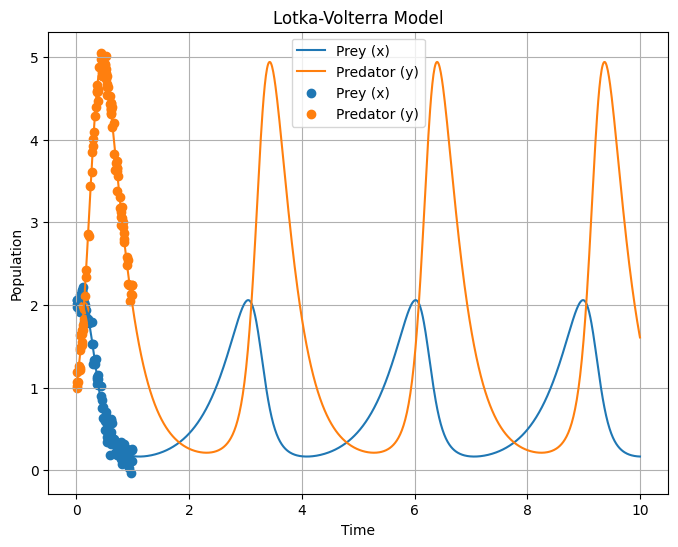

In [25]:
# Generate training data (based on noisy data or the true solution)
# training_t, training_y(prey, predator) noisy with gaussian, true_solution
pool = range(0,100)
idx = np.random.choice(pool, 100, replace=True)
training_t = t[idx]
# reshape to (100, 1)
training_t = training_t[:, np.newaxis]
true_data = solution[idx]
noise = np.random.normal(0, 0.1, true_data.shape)
training_y = true_data + noise

# plot the training datas and the true solution
plt.figure(figsize=(8, 6))
plt.plot(t, solution[:, 0], label='Prey (x)')
plt.plot(t, solution[:, 1], label='Predator (y)')
plt.scatter(training_t, training_y[:, 0], label='Prey (x)')
plt.scatter(training_t, training_y[:, 1], label='Predator (y)')
plt.title('Lotka-Volterra Model')
plt.xlabel('Time')
plt.ylabel('Population')
plt.legend()
plt.grid(True)
plt.show()


# pytorch 

###### helped by chatgpt3.5

In [26]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim

# Define the PINN model
class PINNModel(nn.Module):
    def __init__(self):
        super(PINNModel, self).__init__()
        self.dense1 = nn.Linear(3, 50)  # Input: time, prey, predator
        self.dense2 = nn.Linear(50, 50)
        self.dense3 = nn.Linear(50, 50)
        self.dense4 = nn.Linear(50, 50)
        self.dense5 = nn.Linear(50, 2)  # Output: prey, predator

    def forward(self, t, y):
        inputs = torch.cat([t, y], dim=1)
        x = torch.tanh(self.dense1(inputs))
        x = torch.tanh(self.dense2(x))
        x = torch.tanh(self.dense3(x))
        x = torch.tanh(self.dense4(x))
        return self.dense5(x)

# Loss function
def loss_function(pred, true, t, y):
    alpha = 2.0
    beta = 4.0 / 3.0
    delta = 4.0
    gamma = 3.0

    dy_dt = torch.autograd.grad(pred.sum(), t, create_graph=True)[0] #???????
    dy_dy = torch.autograd.grad(pred.sum(), y, create_graph=True)[0] #???????

    prey, predator = torch.split(pred, 1, dim=1)
    data_loss = torch.mean((pred - true) ** 2)  # Data fitting loss
    physics_loss = torch.mean((dy_dt[:, 0] - (alpha * prey - beta * prey * predator)) ** 2) + \
                   torch.mean((dy_dy[:, 1] - (delta * prey * predator - gamma * predator)) ** 2)

    total_loss = data_loss + physics_loss  # Combined loss
    return total_loss

# Convert to PyTorch tensors
if (type(training_t) is np.ndarray):
    training_t = torch.tensor(training_t, requires_grad=True, dtype=torch.float32)
    training_y = torch.tensor(training_y, requires_grad=True, dtype=torch.float32)
    true_data = torch.tensor(true_data, dtype=torch.float32)

# # Instantiate the PINN model and define optimizer
model = PINNModel()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# # Training loop
num_epochs = 5000  # Adjust as needed
for epoch in range(num_epochs):
    optimizer.zero_grad()
    predictions = model(training_t, training_y)
    loss = loss_function(predictions, true_data, training_t, training_y)
    loss.backward()
    optimizer.step()


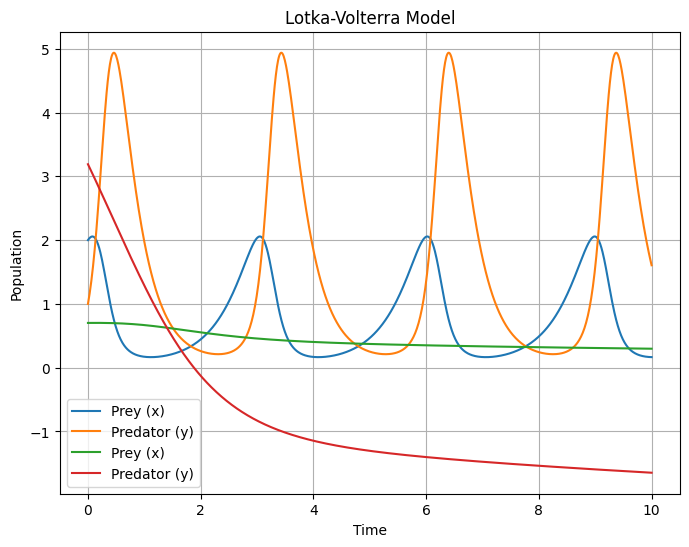

In [27]:
# predict on the test data
test_t = np.linspace(0, 10, 1000)
test_t = test_t[:, np.newaxis]
test_t = torch.tensor(test_t, requires_grad=True, dtype=torch.float32)
test_y = np.zeros((1000, 2))
test_y = torch.tensor(test_y, requires_grad=True, dtype=torch.float32)
test_y = model.forward(test_t, test_y)
# print(test_y.shape)

# # Plot the results
plt.figure(figsize=(8, 6))
plt.plot(t, solution[:, 0], label='Prey (x)')
plt.plot(t, solution[:, 1], label='Predator (y)')
plt.plot(test_t.detach().numpy(), test_y.detach().numpy()[:, 0], label='Prey (x)')
plt.plot(test_t.detach().numpy(), test_y.detach().numpy()[:, 1], label='Predator (y)')
plt.title('Lotka-Volterra Model')
plt.xlabel('Time')
plt.ylabel('Population')
plt.legend()
plt.grid(True)
plt.show()


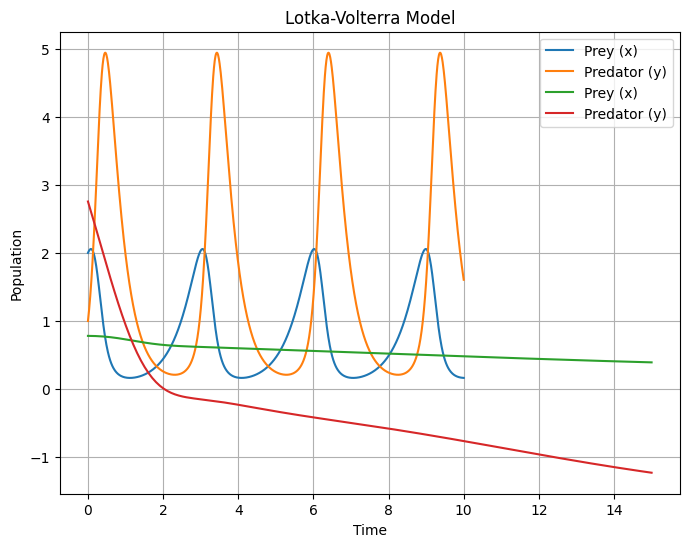

In [28]:
# Generate test time points (new time points for prediction)
test_t = torch.linspace(0, 15, 150).reshape(-1, 1)  # Example: 150 new time points

# Initialize prey and predator populations for predictions
initial_values = torch.tensor([[2, 1]]).repeat(test_t.size(0), 1)  # Initial values for prey and predator

# Combine time and initial values for predictions
test_y = torch.cat((test_t, initial_values), dim=1)

# Predict using the trained PINN model
model.eval()  # Set the model to evaluation mode
with torch.no_grad():
    predictions = model(test_t, initial_values)

# Extract predicted prey and predator populations
predicted_prey, predicted_predator = torch.split(predictions, 1, dim=1)

# You can use these predicted values for analysis or plotting
plt.figure(figsize=(8, 6))
plt.plot(t, solution[:, 0], label='Prey (x)')
plt.plot(t, solution[:, 1], label='Predator (y)')
plt.plot(test_t.detach().numpy(), predicted_prey.detach().numpy(), label='Prey (x)')
plt.plot(test_t.detach().numpy(), predicted_predator.detach().numpy(), label='Predator (y)')
plt.title('Lotka-Volterra Model')
plt.xlabel('Time')
plt.ylabel('Population')
plt.legend()
plt.grid(True)
plt.show()

# normal nural network (Tensorflow)
###### helped by bing chat (gpt4)

In [29]:
import tensorflow as tf

# Generate training data (based on noisy data or the true solution)
# training_t, training_y(prey, predator) noisy with gaussian, true_solution
pool = range(0,100)
idx = np.random.choice(pool, 1000, replace=True)
training_t = t[idx]
# reshape to (100, 1)
training_t = training_t[:, np.newaxis]
true_data = solution[idx]
noise = np.random.normal(0, 0.1, true_data.shape)
training_y = true_data + noise

# Define the neural network architecture
class LVNet(tf.keras.Model):
    def __init__(self):
        super(LVNet, self).__init__()
        self.dense_1 = tf.keras.layers.Dense(20, activation=tf.nn.tanh)
        self.dense_2 = tf.keras.layers.Dense(20, activation=tf.nn.tanh)
        self.dense_3 = tf.keras.layers.Dense(20, activation=tf.nn.tanh)
        self.dense_4 = tf.keras.layers.Dense(20, activation=tf.nn.tanh)
        self.dense_5 = tf.keras.layers.Dense(2)

    def call(self, inputs):
        x = self.dense_1(inputs)
        x = self.dense_2(x)
        x = self.dense_3(x)
        x = self.dense_4(x)
        return self.dense_5(x)

# Define the loss function
def loss_fn(model, t, y):
    with tf.GradientTape(persistent=True) as tape:
        tape.watch(t)
        pred = model(t)
        pred_x, pred_y = tf.unstack(pred, axis=-1)
        pred_dx_dt = tape.gradient(pred_x, t)
        pred_dy_dt = tape.gradient(pred_y, t)
    del tape
    true_dx_dt = alpha * pred_x - beta * pred_x * pred_y
    true_dy_dt = delta * pred_x * pred_y - gamma * pred_y
    # l = (y - pred)^2 + (true_dx_dt - pred_dx_dt)^2 + (true_dy_dt - pred_dy_dt)^2
    return tf.reduce_mean(tf.square(y - pred)) + tf.reduce_mean(tf.square(true_dx_dt - pred_dx_dt)) + tf.reduce_mean(tf.square(true_dy_dt - pred_dy_dt))

# Define the training loop
def train(model, optimizer, t, y):
    with tf.GradientTape() as tape:
        loss = loss_fn(model, t, y)
    grads = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))
    return loss

# Initialize the model and optimizer
model = LVNet()
optimizer = tf.keras.optimizers.Adam()

# Convert the training data to TensorFlow tensors
training_t = tf.convert_to_tensor(training_t, dtype=tf.float32)
training_y = tf.convert_to_tensor(training_y, dtype=tf.float32)

# Train the model
for step in range(5001):
    loss = train(model, optimizer, training_t, training_y)
    if step % 100 == 0:
        print(f"Step: {step}, Loss: {loss}")


Step: 0, Loss: 8.675878524780273
Step: 100, Loss: 2.0456762313842773
Step: 200, Loss: 2.02368426322937
Step: 300, Loss: 2.017839193344116
Step: 400, Loss: 2.0164151191711426
Step: 500, Loss: 2.0159764289855957
Step: 600, Loss: 2.0156915187835693
Step: 700, Loss: 2.015446901321411
Step: 800, Loss: 2.015213966369629
Step: 900, Loss: 2.014971971511841
Step: 1000, Loss: 2.0147006511688232
Step: 1100, Loss: 2.014373302459717
Step: 1200, Loss: 2.0139477252960205
Step: 1300, Loss: 2.0134024620056152
Step: 1400, Loss: 2.0125892162323
Step: 1500, Loss: 2.011367082595825
Step: 1600, Loss: 2.0093255043029785
Step: 1700, Loss: 2.0056021213531494
Step: 1800, Loss: 1.9991564750671387
Step: 1900, Loss: 1.9920604228973389
Step: 2000, Loss: 1.984039068222046
Step: 2100, Loss: 1.9826700687408447
Step: 2200, Loss: 1.982203722000122
Step: 2300, Loss: 1.982282280921936
Step: 2400, Loss: 1.9817806482315063
Step: 2500, Loss: 1.9816153049468994
Step: 2600, Loss: 1.9814720153808594
Step: 2700, Loss: 1.98132133

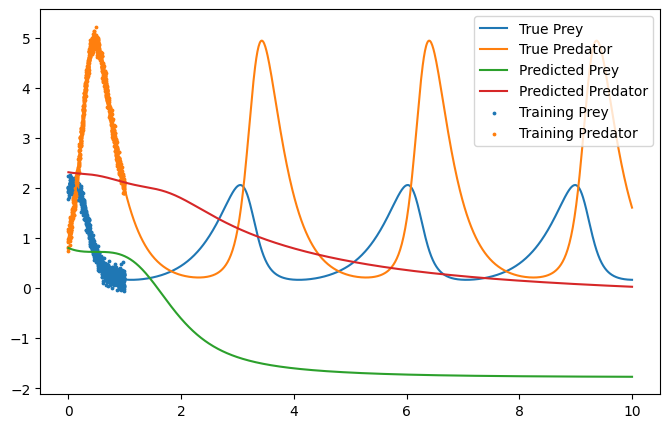

In [30]:
# Generate some test data
test_t = np.linspace(0, 10, 1000)  # Time span
test_t = test_t[:, np.newaxis]  # reshape to (1000, 1)
test_solution = odeint(lotka_volterra, initial_conditions, np.squeeze(test_t), args=(alpha, beta, delta, gamma))

# Convert the test data to TensorFlow tensors
test_t = tf.convert_to_tensor(test_t, dtype=tf.float32)

# Use the model to make predictions
predictions = model(test_t)

# Convert the predictions to a NumPy array
predictions = predictions.numpy()

# Plot the true solution and the model's predictions
plt.figure(figsize=(8, 5))
plt.plot(test_t, test_solution[:, 0], label='True Prey')
plt.plot(test_t, test_solution[:, 1], label='True Predator')
plt.plot(test_t, predictions[:, 0], label='Predicted Prey')
plt.plot(test_t, predictions[:, 1], label='Predicted Predator')
plt.scatter(training_t, training_y[:, 0], label='Training Prey', s=3)
plt.scatter(training_t, training_y[:, 1], label='Training Predator', s=3)
plt.legend()
plt.show()


# PINNs(Tensorflow)
###### helped by bing chat (gpt4)

In [43]:
import tensorflow as tf

# Generate training data (based on noisy data or the true solution)
# training_t, training_y(prey, predator) noisy with gaussian, true_solution
pool = range(0,100)
idx = np.random.choice(pool, 1000, replace=True)
training_t = t[idx]
# reshape to (100, 1)
training_t = training_t[:, np.newaxis]
true_data = solution[idx]
noise = np.random.normal(0, 0.1, true_data.shape)
training_y = true_data + noise

import torch
import torch.nn as nn

class LotkaVolterraPINN(nn.Module):
    def __init__(self, layers, alpha, beta, delta, gamma):
        super().__init__()
        self.alpha = alpha
        self.beta = beta
        self.delta = delta
        self.gamma = gamma
        self.layers = layers
        self.weights, self.biases = self.initialize_NN(layers)

    def initialize_NN(self, layers):
        weights = nn.ParameterList()
        biases = nn.ParameterList()
        for l in range(0, len(layers) - 1):
            weight = nn.Parameter(torch.randn(layers[l], layers[l+1]))
            bias = nn.Parameter(torch.zeros(layers[l+1]))
            weights.append(weight)
            biases.append(bias)
        return weights, biases


    def forward(self, t):
        x = t
        for i, (weight, bias) in enumerate(zip(self.weights, self.biases)):
            x = torch.tanh(torch.mm(x, weight) + bias) if i < len(self.weights) - 1 else torch.mm(x, weight) + bias
        return x

    def net_prey_predator(self, t):
        x = self.forward(t)
        prey = x[:, 0:1]
        predator = x[:, 1:2]

        prey_t = torch.autograd.grad(prey.sum(), t, create_graph=True)[0]
        predator_t = torch.autograd.grad(predator.sum(), t, create_graph=True)[0]

        return prey, predator, prey_t, predator_t

    def compute_loss(self, t, prey, predator):
        prey_pred, predator_pred, prey_t_pred, predator_t_pred = self.net_prey_predator(t)
        return ((prey - prey_pred)**2).mean() + ((predator - predator_pred)**2).mean()

    def train(self, t, prey, predator, num_epochs=5000, learning_rate=1e-3):
        optimizer = torch.optim.Adam(self.parameters(), lr=learning_rate)
        for epoch in range(num_epochs):
            loss = self.compute_loss(t, prey, predator)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            if epoch % 100 == 0:
                print(f'Epoch {epoch}, Loss {loss.item()}')

# Initialize the PINN model
alpha = 2.0
beta = 4.0 / 3.0
delta = 4.0
gamma = 3.0
t_tensor = torch.from_numpy(training_t).float().requires_grad_(True)
y_tensor = torch.from_numpy(training_y).float().requires_grad_(True)

pinn = LotkaVolterraPINN(layers=[1, 20, 20, 2], alpha=alpha, beta=beta, delta=delta, gamma=gamma)
pinn.train(t_tensor, y_tensor[:, 0:1], y_tensor[:, 1:2], num_epochs=20000, learning_rate=1e-3)



Epoch 0, Loss 79.2093734741211
Epoch 100, Loss 14.607870101928711
Epoch 200, Loss 1.4977458715438843
Epoch 300, Loss 0.6821406483650208
Epoch 400, Loss 0.43027204275131226
Epoch 500, Loss 0.31024593114852905
Epoch 600, Loss 0.2377469837665558
Epoch 700, Loss 0.18649451434612274
Epoch 800, Loss 0.14847905933856964
Epoch 900, Loss 0.11987791955471039
Epoch 1000, Loss 0.09785261750221252
Epoch 1100, Loss 0.08047587424516678
Epoch 1200, Loss 0.0665564090013504
Epoch 1300, Loss 0.0553639680147171
Epoch 1400, Loss 0.046430282294750214
Epoch 1500, Loss 0.03942275792360306
Epoch 1600, Loss 0.03406467288732529
Epoch 1700, Loss 0.030091218650341034
Epoch 1800, Loss 0.02723848819732666
Epoch 1900, Loss 0.02525266259908676
Epoch 2000, Loss 0.02390638180077076
Epoch 2100, Loss 0.023010600358247757
Epoch 2200, Loss 0.022419067099690437
Epoch 2300, Loss 0.02202541008591652
Epoch 2400, Loss 0.02175644040107727
Epoch 2500, Loss 0.021564075723290443
Epoch 2600, Loss 0.02141806297004223
Epoch 2700, Loss 

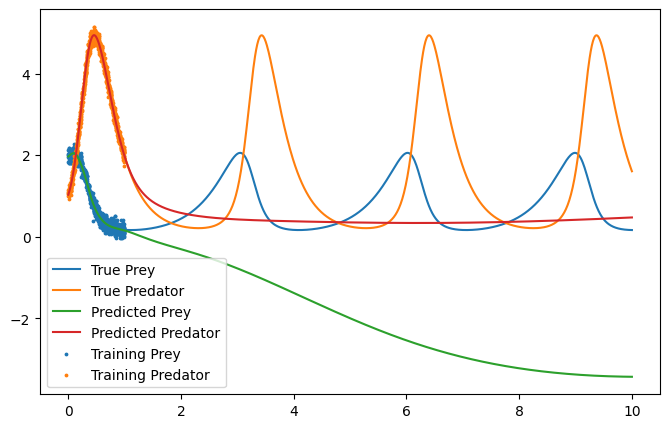

In [44]:
# Generate some test data
test_t = np.linspace(0, 10, 1000)  # Time span
test_t = test_t[:, np.newaxis]  # reshape to (1000, 1)
test_solution = odeint(lotka_volterra, initial_conditions, np.squeeze(test_t), args=(alpha, beta, delta, gamma))

# Convert the test data to PyTorch tensors
test_t = torch.from_numpy(test_t).float()

# Use the model to make predictions
predictions = pinn(test_t)

# Convert the predictions to a NumPy array
predictions = predictions.detach().numpy()

# Plot the true solution and the model's predictions
plt.figure(figsize=(8, 5))
plt.plot(test_t, test_solution[:, 0], label='True Prey')
plt.plot(test_t, test_solution[:, 1], label='True Predator')
plt.plot(test_t, predictions[:, 0], label='Predicted Prey')
plt.plot(test_t, predictions[:, 1], label='Predicted Predator')
plt.scatter(training_t, training_y[:, 0], label='Training Prey', s=3)
plt.scatter(training_t, training_y[:, 1], label='Training Predator', s=3)
plt.legend()
plt.show()

